In [1]:
from typing import Tuple

import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

from src.get_project_data import housing_data, locale_data
pd.options.mode.chained_assignment = None  # default='warn'  # Hide SettingWithCopyWarning

In [2]:
housing_df = housing_data()
locale_df = locale_data()

In [45]:
housing_df1 = housing_df[["date", "zipcode", "zip_name", "pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count"]]
print(housing_df1.shape)
df_full1 = housing_df1.merge(locale_df, how='inner', on="zipcode")
# A blank is 0 for pending_listing_count
df_full1[["pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count"]].fillna(0, inplace=True)
print(df_full1.shape)

df_nans = df_full1[df_full1['LOCALE'].isna()].groupby("zipcode").agg({
                                                                     "zip_name": "first",
                                                                     "LOCALE": "first"})
print(df_nans.shape)
# df_nans.sample(10)

(134947, 7)
(133954, 8)
(0, 2)


In [46]:
housing_df = housing_df[["date", "zipcode", "zip_name", "pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count"]]
print(housing_df.shape)
df_full = housing_df.merge(locale_df, how='inner', on="zipcode")
# A blank is 0 for pending_listing_count
df_full[["pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count"]].fillna(0, inplace=True)
print(df_full.shape)
df_full.sample(10)

(134947, 7)
(133954, 8)


,date,zipcode,zip_name,pending_listing_count,active_listing_count,new_listing_count,total_listing_count,LOCALE
48565,2018-04-01,77035,"houston, tx",40,155,58,194,11
116915,2018-09-01,76110,"fort worth, tx",22,67,24,90,11
105446,2018-09-01,75651,"harleton, tx",0,6,0,6,42
39654,2020-10-01,78124,"marion, tx",13,14,4,28,41
132264,2018-03-01,76888,"voss, tx",1,1,0,2,43
53992,2018-05-01,76044,"godley, tx",23,35,14,57,42
67270,2019-09-01,75568,"naples, tx",2,12,0,14,42
1268,2023-03-01,76305,"wichita falls, tx",3,10,2,12,42
4920,2017-06-01,75240,"dallas, tx",16,13,6,29,11
75739,2020-01-01,76261,"ringgold, tx",0,2,0,2,42


In [47]:
by_month_totals = df_full.groupby("date")\
                         .agg({"pending_listing_count": "sum",
                               "active_listing_count": "sum",
                               "new_listing_count": "sum",
                               "total_listing_count": "sum"})\
                         .rename(columns={"pending_listing_count": "Pending Totals",
                                          "active_listing_count": "Active Listings Totals",
                                          "new_listing_count": "New Listings Totals",
                                          "total_listing_count": "Total Listings"})
by_month_totals.head()

,Pending Totals,Active Listings Totals,New Listings Totals,Total Listings
date,,,,
2016-07-01,42222,95521,38240,137293
2016-08-01,40986,96936,34856,137361
2016-09-01,37550,95494,30316,132494
2016-10-01,34864,94058,30256,128612
2016-11-01,33615,92013,25138,125118


In [48]:
df_grouped = df_full.groupby(["date", "LOCALE"])\
                    .agg({"pending_listing_count": "sum",
                          "active_listing_count": "sum",
                          "new_listing_count": "sum",
                          "total_listing_count": "sum"})
df_grouped["Pending %"] = df_grouped["pending_listing_count"] / by_month_totals["Pending Totals"] * 100
df_grouped["Active Listing %"] = df_grouped["active_listing_count"] / by_month_totals["Active Listings Totals"] * 100
df_grouped["New Listing %"] = df_grouped["new_listing_count"] / by_month_totals["New Listings Totals"] * 100
df_grouped["Total Listing %"] = df_grouped["total_listing_count"] / by_month_totals["Total Listings"] * 100
df_grouped.head(12)

pending_listing_count  active_listing_count  \
date       LOCALE                                                
2016-07-01 11                      11139                 19396   
           12                       1440                  4238   
           13                        210                   670   
           21                      10467                 15516   
           22                        717                  1198   
           23                         14                    66   
           31                        159                   397   
           32                          6                    17   
           41                      12823                 29806   
           42                       4862                 20698   
           43                        385                  3519   
2016-08-01 11                      10732                 19830   

                   new_listing_count  total_listing_count  Pending %  \
date       LOCALE                                                      
2016-07-01 11                   9276                30500  26.381981   
           12                   1892                 5650   3.410544   
           13                    336                  879   0.497371   
           21                   8668                25955  24.790394   
           22                    696                 1879   1.698167   
           23                     24                   78   0.033158   
           31                    148                  549   0.376581   
           32                      0                   22   0.014211   
           41                  11506                42519  30.370423   
           42                   5184                25390  11.515324   
           43                    510                 3872   0.911847   
2016-08-01 11                   8460                30465  26.184551   

                   Active Listing %  New Listing %  Total Listing %  
date       LOCALE                                                    
2016-07-01 11             20.305483      24.257322        22.215262  
           12              4.436721       4.947699         4.115286  
           13              0.701416       0.878661         0.640237  
           21             16.243549      22.667364        18.904824  
           22              1.254174       1.820084         1.368606  
           23              0.069095       0.062762         0.056813  
           31              0.415615       0.387029         0.399875  
           32              0.017797            0.0         0.016024  
           41              31.20361      30.088912        30.969532  
           42             21.668534      13.556485        18.493295  
           43              3.684007       1.333682         2.820246  
2016-08-01 11             20.456796      24.271288        22.178784

## Graphs and Linear Regressions

In [6]:
# Plotting setup
# plot_df = df_grouped.drop("pending_listing_count", axis=1)
land_color_list = ["#eb348c", "#fc4eda", "#e880ff",  # urban
                   "#ff9a26", "#fac852", "#fff759",  # suburban
                   "#1a2ca3", "#5477de", "#6cade6",  # town
                   "#85ed7b", "#59c24f", "#2e8f25",  # rural
                   ]
land_labels = ["Urban Large", "Urban Midsize", "Urban Small",
               "Suburban Large", "Suburban Midsize", "Suburban Small",
               "Town Fringe", "Town Distant", "Town Remote",
               "Rural Fringe", "Rural Distant", "Rural Remote",]

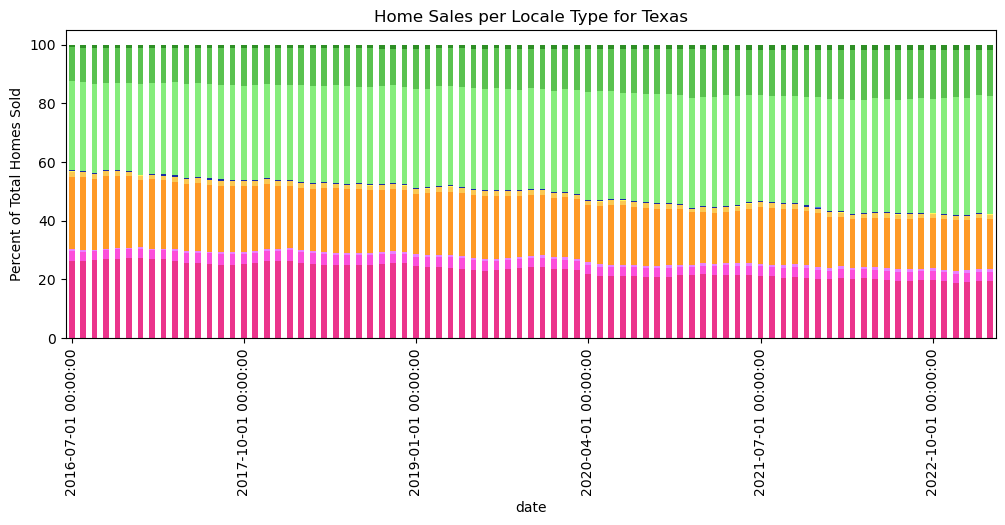

In [49]:
stacked_bar_df = df_grouped.drop(["pending_listing_count", "active_listing_count", "new_listing_count", "total_listing_count",
                                  "Active Listing %", "New Listing %", "Total Listing %"], axis=1)
fig, ax = plt.subplots(figsize=(12, 4))
# this only works with just pending totals in df (drop other columns)
stacked_bar_df.unstack().plot.bar(ax=ax, stacked=True, color=land_color_list, legend=False)
# ax.bar(x=plot_df.unstack().index, stacked=True)
ax.set(ylabel="Percent of Total Homes Sold", title="Home Sales per Locale Type for Texas")
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
plt.show()

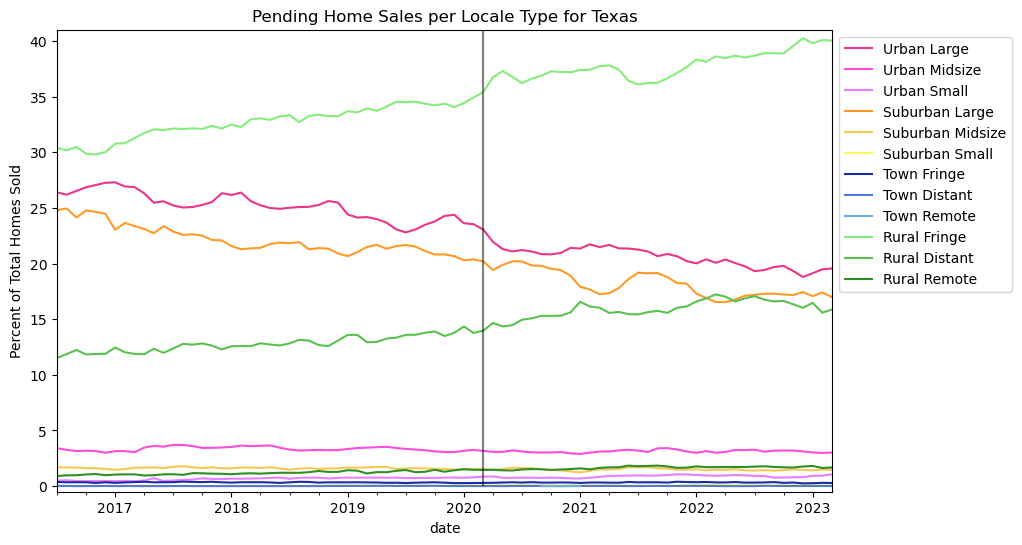

In [50]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="Pending %", color=land_color_list)
ax.set(ylabel="Percent of Total Homes Sold", title="Pending Home Sales per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

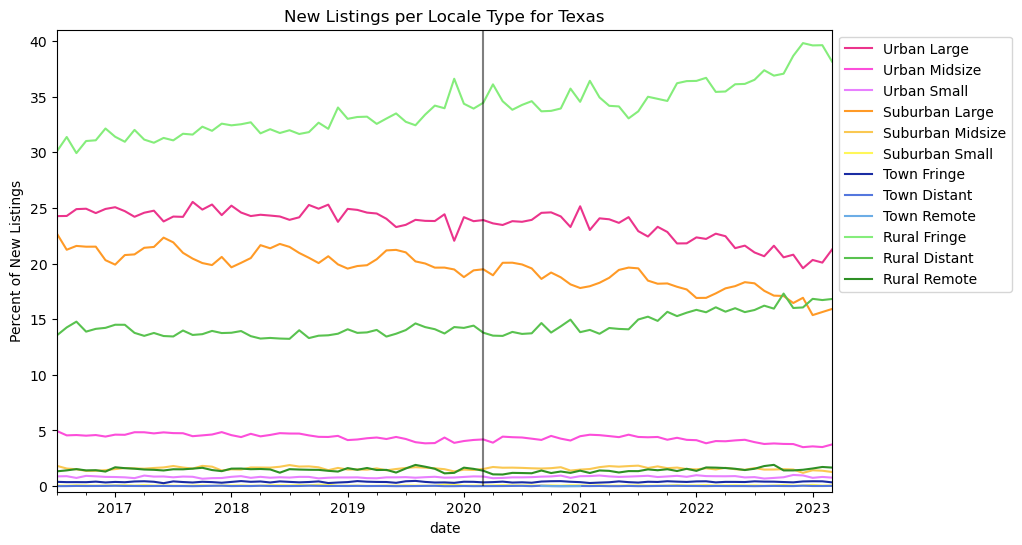

In [51]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="New Listing %", color=land_color_list)
ax.set(ylabel="Percent of New Listings", title="New Listings per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

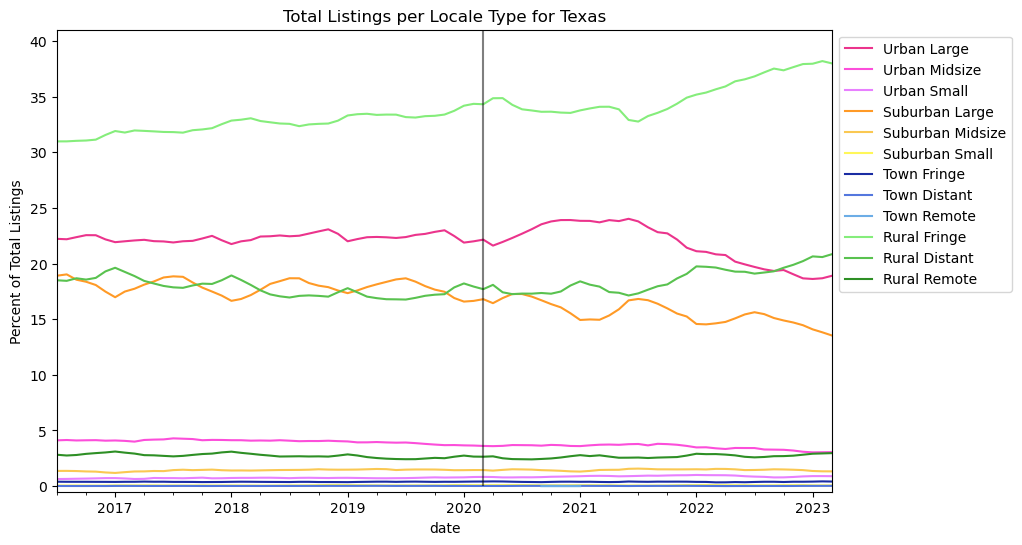

In [52]:
fig, ax = plt.subplots(figsize=(10, 6))
df_grouped.unstack().plot.line(ax=ax, y="Total Listing %", color=land_color_list)
ax.set(ylabel="Percent of Total Listings", title="Total Listings per Locale Type for Texas")
ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(pd.Timestamp(year=2020, month=3, day=13), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.set_ylim(-0.5, 41)
plt.show()

## Regressions

In [53]:
# for regression and plotting with matplotlib, dates need to be a number, we will use ordinal
df_linear_regress_data = df_grouped.reset_index()
df_linear_regress_data["date"] = df_linear_regress_data["date"].apply(pd.Timestamp.toordinal)

# Dates
DATE_START = "2016-7-1"
DATE_END = "2023-3-1"
COVID_START_TX = "2020-3-13"
TS_COVID_START_TX = pd.Timestamp(COVID_START_TX)
COVID_PLUS_1_YEAR = "2021-4-1"
TS_COVID_PLUS_1_YEAR = pd.Timestamp(COVID_PLUS_1_YEAR)

# linespace for plotting linear regressions
ls_before_covid = pd.date_range(DATE_START, COVID_START_TX, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)
ls_after_covid = pd.date_range(COVID_PLUS_1_YEAR, DATE_END, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)
ls_full = pd.date_range(DATE_START, DATE_END, freq="MS").to_series(name="date").apply(pd.Timestamp.toordinal).reset_index(drop=True)

pre_covid_data = df_linear_regress_data.loc[df_linear_regress_data["date"] < TS_COVID_START_TX.toordinal(), :]
post_covid_data = df_linear_regress_data.loc[df_linear_regress_data["date"] >= TS_COVID_PLUS_1_YEAR.toordinal(), :]
print("Pre Covid data shape:", pre_covid_data.shape)
print("During/After Covid data shape:", post_covid_data.shape)
print("Full data shape:", df_linear_regress_data.shape)

Pre Covid data shape: (495, 10)
During/After Covid data shape: (264, 10)
Full data shape: (896, 10)


In [54]:
def linear_regression_per_locale(data: pd.DataFrame, column: str, locale: int) -> Tuple[float]:
    """Gives a linear regression for the given column vs date as ordinal in data and at the given locale.

    :param data: dataFrame
    :param column: name of column
    :param locale: integer locale value
    :return: linear regression tuple
    """
    # assume data as "date" as ordinal Int and "LOCALE" as Int columns
    _data_df = data.loc[data["LOCALE"] == locale, [column, "date"]]
    _data_df = _data_df.astype(float)  # Fixes strange error AttributeError
    return st.linregress(_data_df["date"], _data_df[column])

In [55]:
def plot_regressions(ax: plt.Axes, base_data: pd.DataFrame,
                     base_color: str, locale: int, column: str,
                     pre_line_color: str, post_line_color: str,
                     useFullRegression: bool = True,
                     extendPreCovidRegression: bool = False):
    # Calculate Regressions
    regress_pre = linear_regression_per_locale(pre_covid_data, column, locale)
    regress_post = linear_regression_per_locale(post_covid_data, column, locale)
    
    # Plot regressions and base line
    ax.plot(base_data.loc[base_data["LOCALE"] == locale, "date"],
            base_data.loc[base_data["LOCALE"] == locale, column], color=base_color)
    # pre covid regression plot
    if extendPreCovidRegression:  # plot over full extent of graph
        ax.plot(ls_full, regress_pre.slope * ls_full + regress_pre.intercept, color=pre_line_color, linestyle="dotted")
    else:  # plot only up to Covid Start
        ax.plot(ls_before_covid, regress_pre.slope * ls_before_covid + regress_pre.intercept, color=pre_line_color, linestyle="dotted")
    # post covid regression plot
    ax.plot(ls_after_covid, regress_post.slope * ls_after_covid + regress_post.intercept, color=post_line_color, linestyle="dotted")

    if useFullRegression:
        regress_full = linear_regression_per_locale(df_linear_regress_data, column, locale)
        ax.plot(ls_full, regress_full.slope * ls_full + regress_full.intercept, color=base_color, linestyle="dashed", alpha=0.5)

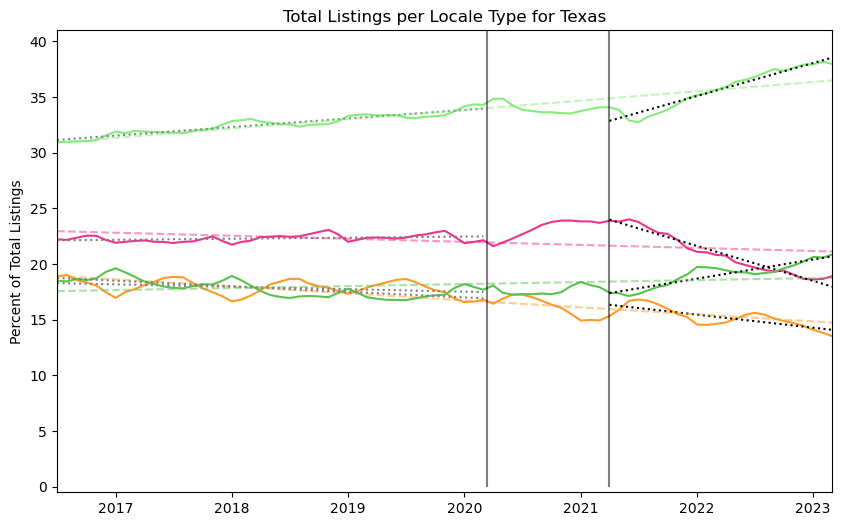

In [56]:
# Add regression lines
fig, ax = plt.subplots(figsize=(10, 6))
plot_regressions(ax, df_linear_regress_data, "#85ed7b", 41, "Total Listing %", "gray", "black")
plot_regressions(ax, df_linear_regress_data, "#eb348c", 11, "Total Listing %", "gray", "black")
plot_regressions(ax, df_linear_regress_data, "#ff9a26", 21, "Total Listing %", "gray", "black")
plot_regressions(ax, df_linear_regress_data, "#59c24f", 42, "Total Listing %", "gray", "black")
ax.set(ylabel="Percent of Total Listings", title="Total Listings per Locale Type for Texas")
# ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(TS_COVID_START_TX.toordinal(), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.vlines(TS_COVID_PLUS_1_YEAR.toordinal(), colors='black', ymin=0, ymax=41, label="1 Year Later", alpha=.50)
ax.set_ylim(-0.5, 41)
# set ticks on year start and display as string, not ordinal
ax.set_xlim(pd.Timestamp("2016-7-1").toordinal(), pd.Timestamp("2023-3-1").toordinal())
dates = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]  # Will automatically be set to 1st day of the year
ax.set_xticks(pd.to_datetime(dates, format="%Y").to_series().apply(pd.Timestamp.toordinal), labels=dates)
plt.show()

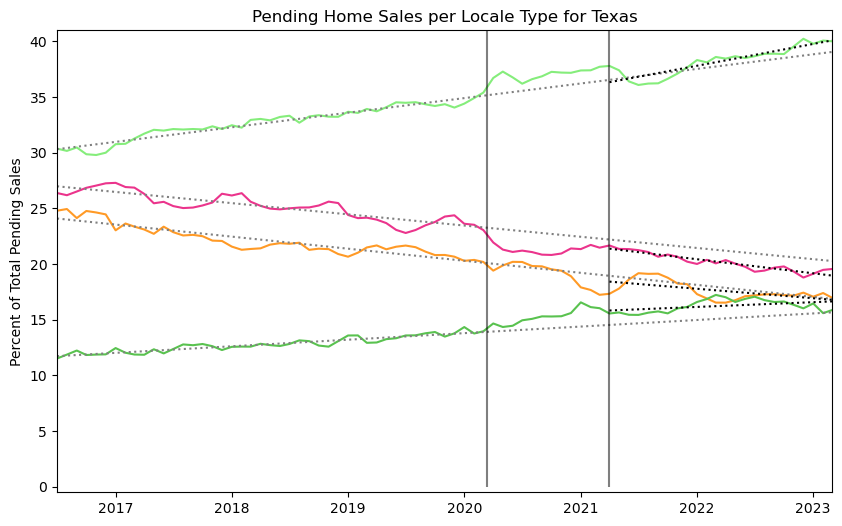

In [57]:
# Add regression lines
fig, ax = plt.subplots(figsize=(10, 6))
plot_regressions(ax, df_linear_regress_data, "#85ed7b", 41, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#eb348c", 11, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#ff9a26", 21, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
plot_regressions(ax, df_linear_regress_data, "#59c24f", 42, "Pending %", "gray", "black", useFullRegression=False, extendPreCovidRegression=True)
ax.set(ylabel="Percent of Total Pending Sales", title="Pending Home Sales per Locale Type for Texas")
# ax.legend(labels=land_labels, bbox_to_anchor=(1.0, 1.0))
ax.vlines(TS_COVID_START_TX.toordinal(), colors='black', ymin=0, ymax=41, label="Disaster Declared in Texas", alpha=.50)
ax.vlines(TS_COVID_PLUS_1_YEAR.toordinal(), colors='black', ymin=0, ymax=41, label="1 Year Later", alpha=.50)
ax.set_ylim(-0.5, 41)
# set ticks on year start and display as string, not ordinal
ax.set_xlim(pd.Timestamp("2016-7-1").toordinal(), pd.Timestamp("2023-3-1").toordinal())
dates = ["2017", "2018", "2019", "2020", "2021", "2022", "2023"]  # Will automatically be set to 1st day of the year
ax.set_xticks(pd.to_datetime(dates, format="%Y").to_series().apply(pd.Timestamp.toordinal), labels=dates)
plt.show()

In [58]:
def regression_summary(regress_df_column: str, calculate_tuple: Tuple[Tuple[str, int]]) -> pd.DataFrame:
    """Create a table of slopes and r-values for Pre, Post, Full linear regressions

    :param regress_df_column: column from linear_regression dataFrame to use
    :param calculate_tuple: tuple of tuples containing Locale name and Locale int
    :return: summary data frame with row for each item in `calculate_tuple`
    """
    lin_regress_summary = []
    for locale_type in calculate_tuple:
        regress_pre = linear_regression_per_locale(pre_covid_data, regress_df_column, locale_type[1])
        regress_post = linear_regression_per_locale(post_covid_data, regress_df_column, locale_type[1])
        regress_full = linear_regression_per_locale(df_linear_regress_data, regress_df_column, locale_type[1])
        line_summary = {"Pre Slope": regress_pre.slope,
                        "Pre r-value": regress_pre.rvalue,
                        "Post Slope": regress_post.slope,
                        "Post r-value": regress_post.rvalue,
                        "Full Slope": regress_full.slope,
                        "Full r-value": regress_full.rvalue}
        lin_regress_summary.append(line_summary)
    df_regress_summary = pd.DataFrame(lin_regress_summary, index=[item[0] for item in calculate_tuple])
    return df_regress_summary

Display slopes of largest 4 locales to compare.

In [59]:
locales_to_calculate = (("Rural Distant", 42), ("Rural Fringe", 41), ("Suburban Large", 21), ("Urban Large", 11))
regression_summary("Pending %", locales_to_calculate)

,Pre Slope,Pre r-value,Post Slope,Post r-value,Full Slope,Full r-value
Rural Distant,0.001616,0.932290,0.001168,0.433460,0.002299,0.959896
Rural Fringe,0.003590,0.966711,0.005371,0.903900,0.003958,0.979937
Suburban Large,-0.002967,-0.910687,-0.002330,-0.607278,-0.003153,-0.965014
Urban Large,-0.002757,-0.885360,-0.003459,-0.936190,-0.003445,-0.970166


Slopes of post covid vs pre covid are almost exactly the same

In [60]:
regression_summary("Total Listing %", locales_to_calculate)

,Pre Slope,Pre r-value,Post Slope,Post r-value,Full Slope,Full r-value
Rural Distant,-0.001366,-0.713314,0.004725,0.916745,0.000491,0.346166
Rural Fringe,0.002104,0.945735,0.008120,0.967129,0.002292,0.896224
Suburban Large,-0.000598,-0.348205,-0.003219,-0.778820,-0.001724,-0.858054
Urban Large,0.000264,0.336924,-0.008597,-0.979871,-0.000750,-0.406328


Slopes for Total Listing % Have a significant change 1 year into Covid. All 4 above get steeper

# Per Zip Code
Which Zip codes are seeing most increase/decrease in pending sales as compared to the 2 years before Covid?

In [90]:
time_before_start, time_before_end = pd.Timestamp("2018-3-1"), pd.Timestamp("2020-3-1")
time_after_start, time_after_end = pd.Timestamp("2021-3-1"), pd.Timestamp("2023-3-1")
df_zips_pending_sales_before = df_full[df_full["date"].between(time_before_start, time_before_end)]\
                                                      .groupby("zipcode")\
                                                      .agg({"zip_name": "first",
                                                            "LOCALE": "first",
                                                            "pending_listing_count": "sum"})\
                                                      .dropna(subset=["LOCALE"])\
                                                      .rename(columns={"pending_listing_count": "Pending Before"})
df_zips_pending_sales_after = df_full[df_full["date"].between(time_after_start, time_after_end)]\
                                                     .groupby("zipcode")\
                                                     .agg({"zip_name": "first",
                                                           "LOCALE": "first",
                                                           "pending_listing_count": "sum"})\
                                                     .dropna(subset=["LOCALE"])\
                                                     .rename(columns={"pending_listing_count": "Pending After"})
df_zips_pending_sales_before.head(8)
print("df_zips_pending_sales_before:", df_zips_pending_sales_before.shape)
print("df_zips_pending_sales_after:", df_zips_pending_sales_after.shape)
df_zips_pending_together = pd.merge(df_zips_pending_sales_before, df_zips_pending_sales_after, how="outer", on="zipcode")
df_zips_pending_together = df_zips_pending_together.drop(["zip_name_y", "LOCALE_y"], axis=1)\
                                                   .rename(columns={"zip_name_x": "zip_name",
                                                                    "LOCALE_x": "LOCALE"})#\
                                                   #.fillna(0)
df_zips_pending_together["% Change"] = (df_zips_pending_together["Pending After"] - df_zips_pending_together["Pending Before"]) / df_zips_pending_together["Pending Before"] * 100
print("df_zips_pending_together:", df_zips_pending_together.shape)
df_zips_pending_together.head()

df_zips_pending_sales_before: (1836, 3)
df_zips_pending_sales_after: (1827, 3)
df_zips_pending_together: (1882, 5)


,zip_name,LOCALE,Pending Before,Pending After,% Change
zipcode,,,,,
75001,"addison, tx",21,407,711,74.692875
75002,"allen, tx",21,2483,2389,-3.785743
75006,"carrollton, tx",21,1083,1199,10.710988
75007,"carrollton, tx",21,1718,1444,-15.948778
75009,"celina, tx",41,2107,3664,73.896535


In [91]:
print("Before NA count", df_zips_pending_together["Pending Before"].isna().sum())
print("After NA count", df_zips_pending_together["Pending After"].isna().sum())

Before NA count 46
After NA count 55


## Plot Percent Change by Zip Code

In [74]:
# imports
import geopandas as gpd
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LinearSegmentedColormap

In [80]:
# gradient
percent_change_colors = [(0, "#b30c00"),    # -100
                         (0.24, "#ffc7c7"), # 0
                         (0.25, "#e8e8e8"), # 0
                         (0.26, "#dcffc7"), # 0
                         (0.5, "#68cf38"),  # 100
                         (0.75, "#34edb6"), # 200
                         (1, "#6a4ad4")]    # 300
percent_change_cmap = LinearSegmentedColormap.from_list("percent change", percent_change_colors)

In [20]:
# read shape file
# Zip Codes Shape File
df_zipcodes = gpd.read_file(r'C:\Users\Zachary\Downloads\tl_2020_us_zcta520\tl_2020_us_zcta520.shp')
# rename columns and convert zipcode to int
df_zipcodes.rename(columns={'ZCTA5CE20':'zipcode'}, inplace=True)
df_zipcodes["zipcode"] = df_zipcodes["zipcode"].astype(int)
# Keep only Texas Zip Codes
df_zipcodes = df_zipcodes[df_zipcodes["zipcode"].between(75000, 79999)]

# States Shape File
df_state = gpd.read_file(r"C:\Users\Zachary\Downloads\tl_2020_us_state\tl_2020_us_state.shp")
df_state[["REGION", "DIVISION", "STATEFP"]] = df_state[["REGION", "DIVISION", "STATEFP"]].astype(int)

In [84]:
# create geopandas DataFrame
# geo_zip_code_percent_change_df = gpd.merge(df_zips_pending_together, df_zipcodes["geometry"], how="inner", on="zipcode")
pd_zip_code_merge = df_zips_pending_together.merge(df_zipcodes[["geometry", "zipcode"]], how="inner", on="zipcode")
gpd_zip_code_merge = gpd.GeoDataFrame(pd_zip_code_merge, geometry='geometry')

In [85]:
# pandas Float needs to be standard float instead
gpd_zip_code_merge["% Change"] = gpd_zip_code_merge["% Change"].astype(float)
gpd_zip_code_merge.dtypes

zipcode              int64
zip_name            object
LOCALE               Int32
Pending Before       Int64
Pending After        Int64
% Change           float64
geometry          geometry
dtype: object

In [86]:
print("Min/Max values:", gpd_zip_code_merge["% Change"].min(), gpd_zip_code_merge["% Change"].max())

Min/Max values: -100.0 inf


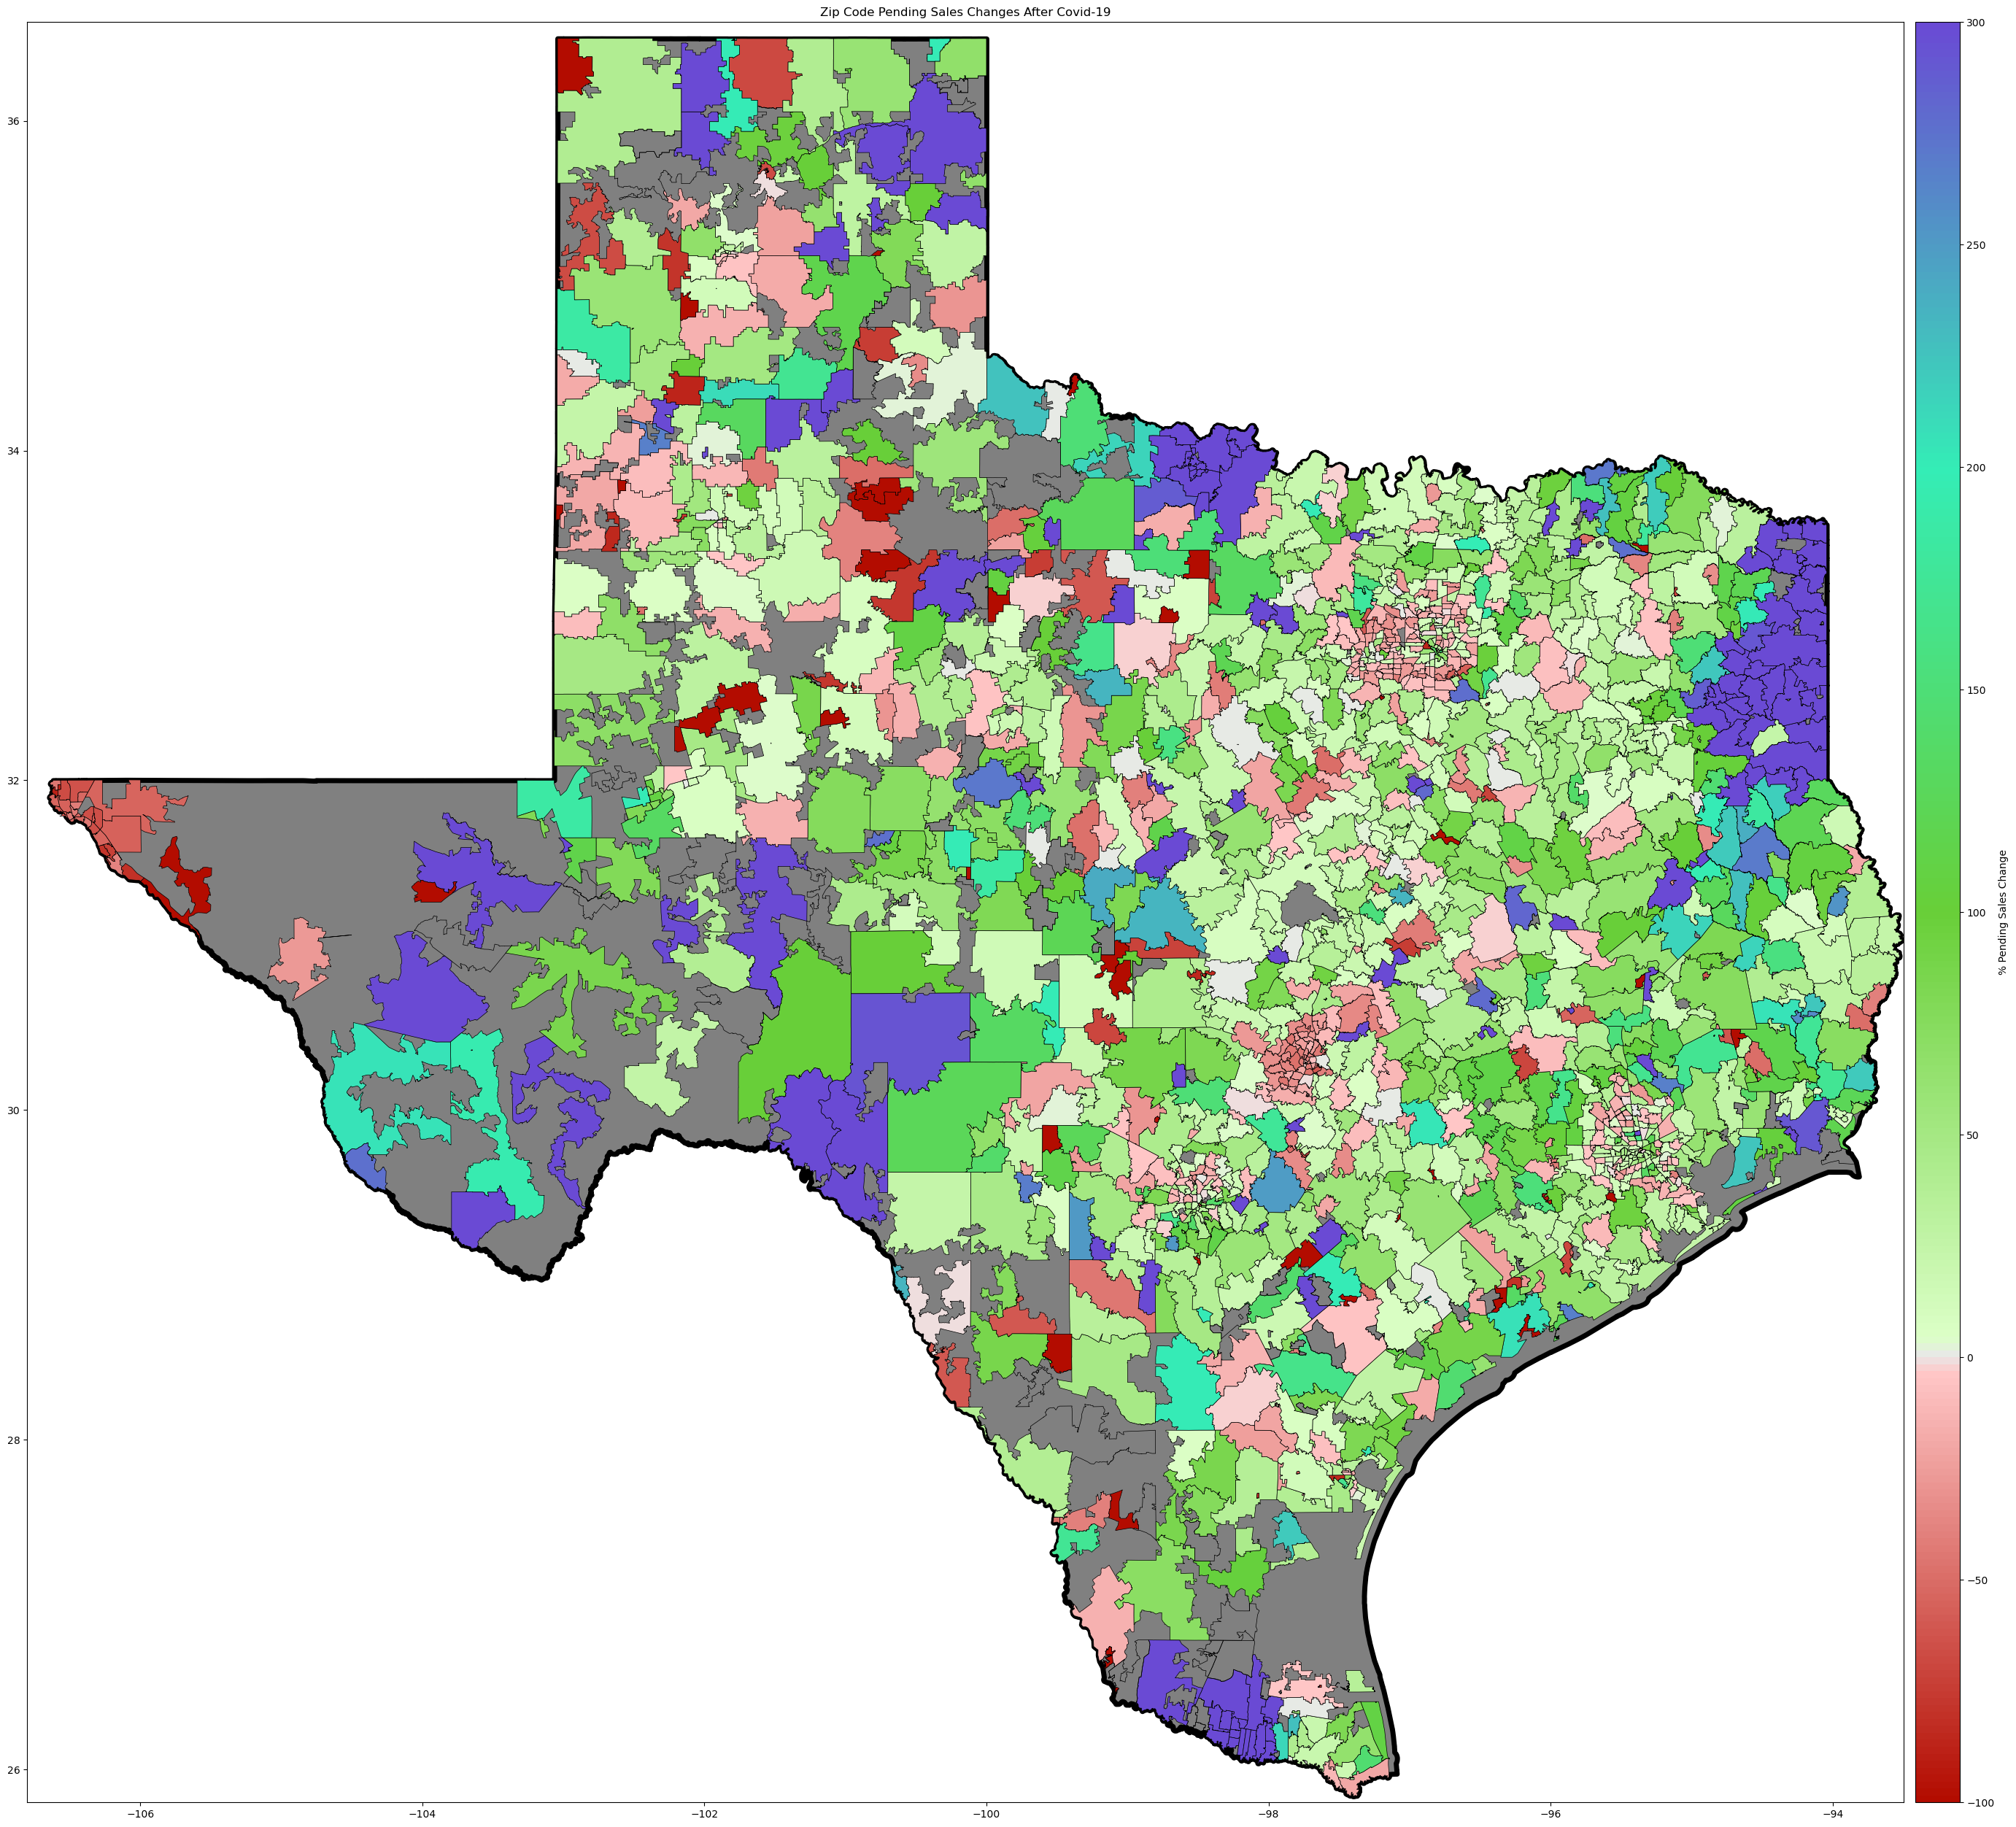

In [87]:
# see https://geopandas.org/en/latest/docs/user_guide/mapping.html
fig, ax = plt.subplots(figsize=(30, 30))
plt.subplots_adjust(left=0.04, right=0.995, top=0.96, bottom=0.08)
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="2%", pad=-2)
base = df_state[df_state["STATEFP"] == 48].plot(ax=ax, color="gray", edgecolor='black', linewidth=5)
gpd_zip_code_merge.plot(ax=ax,
                        column='% Change',
                        edgecolor="black",
                        linewidth=0.5,
                        cmap=percent_change_cmap,
                        vmin=-100,
                        vmax=300,
                        legend=True,
                        cax=cax,
                        legend_kwds={'label': "% Pending Sales Change", 'orientation': "vertical"}
                        )
ax.set_title("Zip Code Pending Sales Changes After Covid-19")
ax.set_xlim(-106.8, -93.5)
ax.set_ylim(25.8, 36.6)
plt.show()